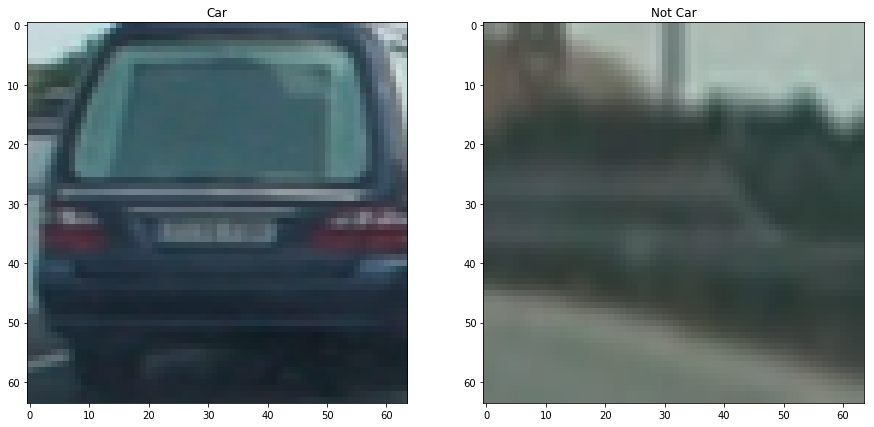

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

car_img = mpimg.imread('data/vehicles/GTI_Left/image0054.png')
fig = plt.figure(figsize=(15, 9))  
subplot = fig.add_subplot(121)
subplot.imshow(car_img, cmap='gray')
subplot.set_title("Car")

not_car_img = mpimg.imread('data/non-vehicles/GTI/image17.png')
subplot = fig.add_subplot(122)
subplot.imshow(not_car_img, cmap='gray')
subplot.set_title("Not Car")
plt.show()


## Histogram of Oriented Gradients (HOG)

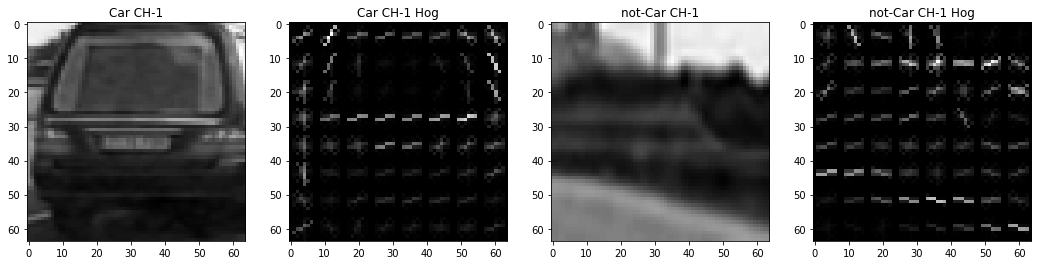

In [13]:
from feature_extraction import *

orient = 9
pix_per_cell = 8
cell_per_block = 2

color_space = 'YCrCb'
hog_channel = 'All'

car_scaled_img = (car_img * 255).astype(np.uint8)
not_car_scaled_img = (not_car_img * 255).astype(np.uint8)

feature_image = car_scaled_img[:,:,0]
features, out_img = get_hog_features(feature_image, orient, pix_per_cell, cell_per_block, vis=True)

fig = plt.figure(figsize=(18, 9))  
subplot = fig.add_subplot(141)
subplot.imshow(feature_image, cmap='gray')
subplot.set_title("Car CH-1")

subplot = fig.add_subplot(142)
subplot.imshow(out_img, cmap='gray')
subplot.set_title("Car CH-1 Hog")

feature_image = not_car_scaled_img[:,:,0]
features, out_img = get_hog_features(feature_image, orient, pix_per_cell, cell_per_block, vis=True)

subplot = fig.add_subplot(143)
subplot.imshow(feature_image, cmap='gray')
subplot.set_title("not-Car CH-1")

subplot = fig.add_subplot(144)
subplot.imshow(out_img, cmap='gray')
subplot.set_title("not-Car CH-1 Hog")

plt.show()
        

### Sliding Window Search

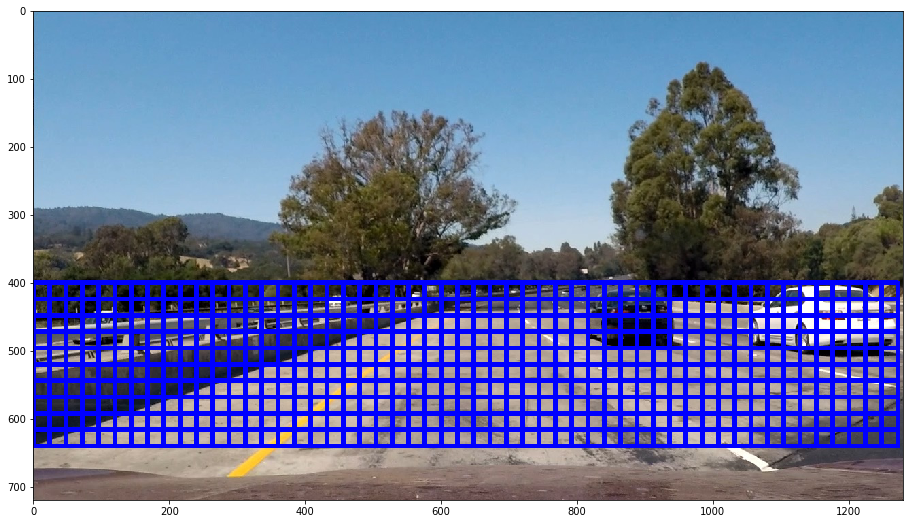

In [65]:
from detect import *

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

img = mpimg.imread('test_images/test1.jpg')
windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                xy_window=(96, 96), xy_overlap=(0.75, 0.75))
windows += slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                xy_window=(96, 96), xy_overlap=(0.5, 0.5))    
draw_img = draw_boxes(img, windows)

fig = plt.figure(figsize=(18, 9)) 
plt.imshow(draw_img)


## Build the pipeline

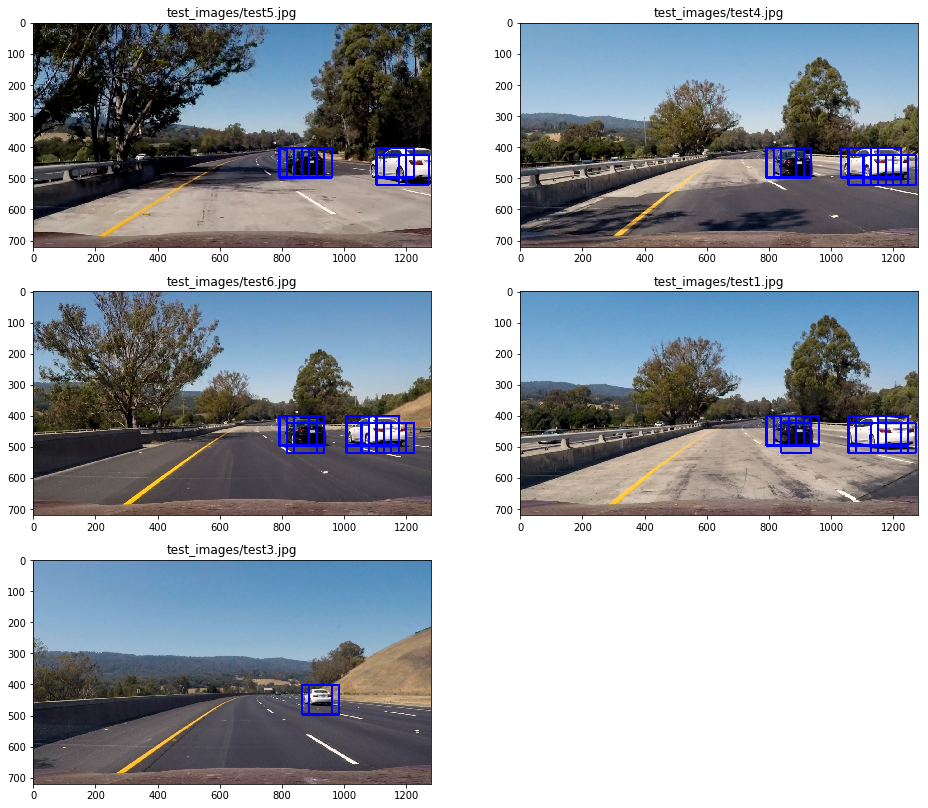

In [66]:
import glob

images = []
images.extend(glob.glob('test_images/*'))

fig = plt.figure(figsize=(16, 14))  

i = 1
for filename in images:
    img = mpimg.imread(filename)
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    windows += slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))   
    hot_windows = search_windows(img, windows, clf, scaler, color_space=color_space,
                                    spatial_size=spatial_size, hist_bins=hist_bins,
                                    orient=orient, pix_per_cell=pix_per_cell,
                                    cell_per_block=cell_per_block,
                                    hog_channel=hog_channel)
    if len(hot_windows) > 0:
        draw_img = draw_boxes(img, hot_windows)
        subplot = fig.add_subplot(3, 2, i)
        i += 1
        subplot.imshow(draw_img)
        subplot.set_title(filename)
plt.show()    


## Combine overlapping detections and remove false positives.

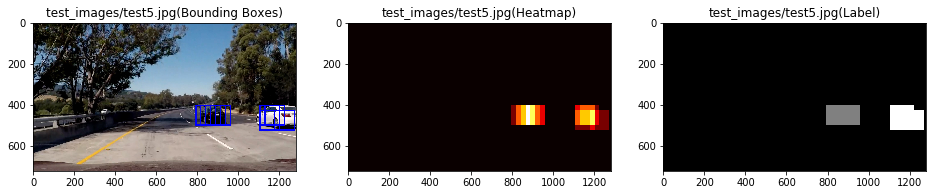

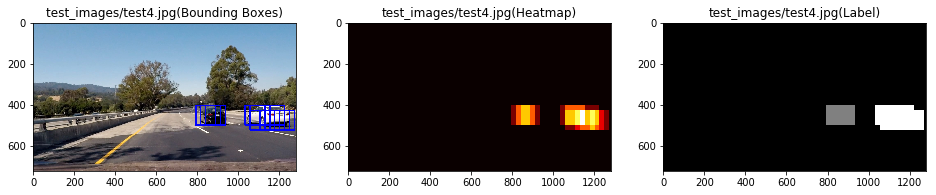

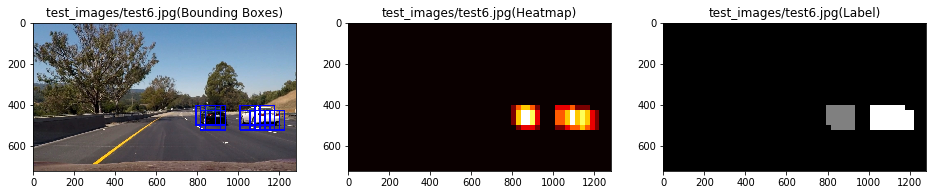

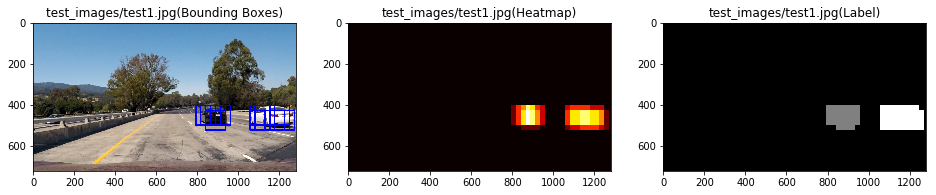

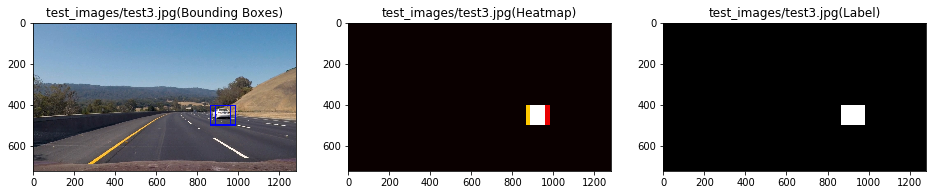

In [64]:
y_start_stop = [400, 656]
for filename in images:
    img = mpimg.imread(filename)
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                        xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    windows += slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                        xy_window=(96, 96), xy_overlap=(0.5, 0.5))    
    hot_windows = search_windows(img, windows, clf, scaler, color_space=color_space,
                                    spatial_size=spatial_size, hist_bins=hist_bins,
                                    orient=orient, pix_per_cell=pix_per_cell,
                                    cell_per_block=cell_per_block,
                                    hog_channel=hog_channel)
    if len(hot_windows) == 0:
        continue

    fig = plt.figure(figsize=(16, 8))    
    draw_img = draw_boxes(img, hot_windows)
    subplot = fig.add_subplot(131)
    subplot.imshow(draw_img)
    subplot.set_title(filename + '(Bounding Boxes)')
    
    heatmap = np.zeros_like(img[:,:,0])
    heatmap = add_heat(heatmap, hot_windows)
    subplot = fig.add_subplot(132)
    subplot.imshow(heatmap, cmap='hot')
    subplot.set_title(filename + '(Heatmap)')

    labels = label(heatmap)
    subplot = fig.add_subplot(133)
    subplot.imshow(labels[0], cmap='gray')
    subplot.set_title(filename + '(Label)')
    plt.show()

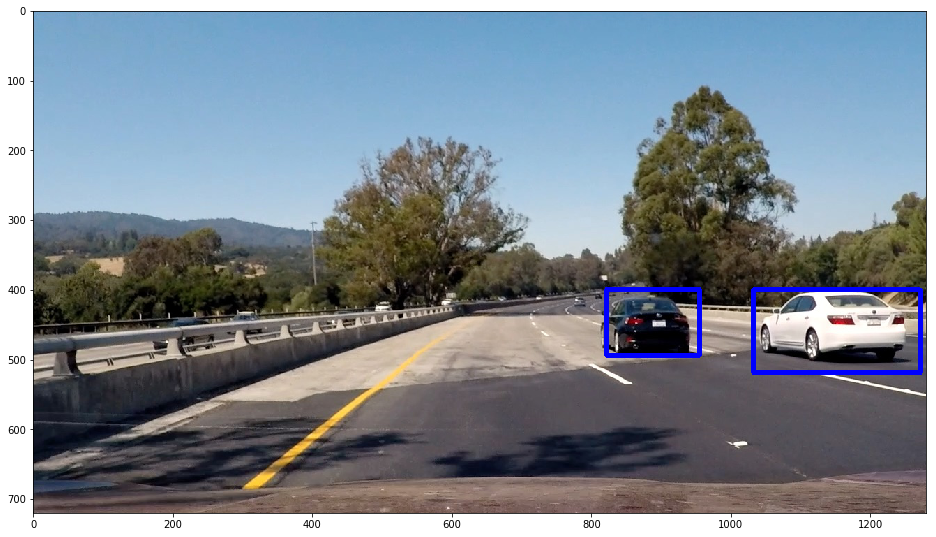

In [67]:
img = mpimg.imread('test_images/test4.jpg')
windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                xy_window=(96, 96), xy_overlap=(0.75, 0.75))
windows += slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                xy_window=(96, 96), xy_overlap=(0.5, 0.5))   
hot_windows = search_windows(img, windows, clf, scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel)
heatmap = np.zeros_like(img[:,:,0])
heatmap = add_heat(heatmap, hot_windows)
labels = label(heatmap)
cars = find_cars(cars, labels)

# Draw bounding boxes around the detected cars
for car in cars:
    cv2.rectangle(img, (car.bbox[0], car.bbox[1]),
              (car.bbox[2], car.bbox[3]), (0,0,255), 6)
    
fig = plt.figure(figsize=(16, 14))     
plt.imshow(img)    
plt.show()
    